In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
import axelrod as axl

In [28]:
#Defining data to train model on
url = "https://raw.githubusercontent.com/jmaxwallace/Capstone/main/model_base.csv"
df = pd.read_csv(url)

In [30]:
#Initial Data Transformations
interaction = df['Interaction index']
final_scores = df['Score']
turns = df.drop(columns = ['Interaction index', 'Player index', 'Opponent index', 'Player name',
       'Opponent name', 'Score', 'Score per turn', 'Initial cooperation'])

In [32]:
def create_dataset(turns, final_scores, N):
    """
    Generates the X (features) and y (targets) variables for a dual-output model.
    
    Parameters:
    - turns: DataFrame where each row is one half of a game (strategy A's moves in row 0, strategy B's in row 1)
    - final_scores: Array of final scores for each game
    - N: Lookback window size (Number of previous turns to consider)

    Returns:
    - X: Features (input data) of shape (num_samples, 2 * N) 
    - y: Targets (output data) of shape (num_samples, 2) (final scores for both strategies)
    """
    
    X = []
    y = []

    # Loop over each game, assuming games are grouped in pairs of rows
    for game_idx in range(0, len(turns), 2):
        # Get the moves for Strategy A and Strategy B
        strat_A_moves = turns.iloc[game_idx].values
        strat_B_moves = turns.iloc[game_idx + 1].values

        # Get the final scores for Strategy A and Strategy B
        score_A = final_scores[game_idx]
        score_B = final_scores[game_idx + 1]

        # Generate samples for each turn from N to 200 (based on lookback)
        for turn in range(N, 200):
            # Get the most recent N moves for both strategies
            A_recent = strat_A_moves[turn-N:turn]
            B_recent = strat_B_moves[turn-N:turn]

            # Combine the recent moves into a single input sample
            X.append(np.hstack([A_recent, B_recent]))
            # Append the corresponding final scores to y
            y.append([score_A, score_B])

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # Normalize moves
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

In [34]:
def build_opponent_prediction_dataset(df, lookback):
    """
    Build dataset to predict opponent's move at time t,
    using previous N moves of both strategies.
    
    Assumes every 2 rows = 1 game.
    Even index = strategy A, odd index = strategy B.
    """
    X = []
    y = []
    
    for i in range(0, len(df), 2):  # iterate in pairs
        strategy_A = df.iloc[i].values
        strategy_B = df.iloc[i+1].values

        for t in range(lookback, 200):
            features = np.concatenate([strategy_A[t-lookback:t], strategy_B[t-lookback:t]])
            target = strategy_B[t]  # predict opponent's move (B)
            X.append(features)
            y.append(target)

    return np.array(X), np.array(y)

In [36]:
#Model Generation for progressively larger lookback windows
lr10 = LinearRegression()
lr20 = LinearRegression()
lr40 = LinearRegression()
lr80 = LinearRegression()
lr120 = LinearRegression()
lr180 = LinearRegression()

#Creating Models for N = 10, 20, 40, 80, 120, 180
X10, y10 = create_dataset(turns, final_scores, 10)
model10 = lr10.fit(X10,y10)

X20, y20 = create_dataset(turns, final_scores, 20)
model20 = lr20.fit(X20,y20)

X40, y40 = create_dataset(turns, final_scores, 40)
model40 = lr40.fit(X40,y40)

X80, y80 = create_dataset(turns, final_scores, 80)
model80 = lr80.fit(X80,y80)

X120, y120 = create_dataset(turns, final_scores, 120)
model120 = lr120.fit(X120,y120)

X180, y180 = create_dataset(turns, final_scores, 180)
model180 = lr180.fit(X180,y180)

In [38]:
#Creating dictionary of the models
score_models = {
    10: model10,
    20: model20,
    40: model40,
    80: model80,
    120: model120,
    180: model180
}
#Set Length of opponent lookback, should be equal to N-1 of lowest N model, or keep same if lowest N model is >= 10
opp_lookback = 9

In [73]:
X_moves, y_moves = build_opponent_prediction_dataset(turns, opp_lookback)

LogR = LogisticRegression()
opponent_model = LogR.fit(X_moves, y_moves)

In [121]:
import numpy as np
from axelrod.action import Action
from axelrod.player import Player

C, D = Action.C, Action.D

class MyStrategy(Player):
    """
    Predictive Machine Learning Strategy:
      – Uses a logistic model to predict opponent’s next move
      – Uses one of six linear‐regression models (10,20,40,80,120,180 lookback)
        to predict final score under both C and D
      – Chooses the move that yields the higher predicted final score
      – Defaults to Tit-for-Tat until models are available
    """

    name = "MyStrategy"
    classifier = {
        "memory_depth": float("inf"),
        "stochastic":    False,
        "long_run_time": False,
        "inspects_source":  False,
        "manipulates_source": False,
        "manipulates_state": False,
    }

    def __init__(self,
                 score_models=None,
                 opponent_model=None,
                 opp_lookback=None):
        super().__init__()

        # Define all windows up front so attributes always exist
        self.lookback_turns   = [10, 20, 40, 80, 120, 180]
        self.sorted_lookbacks = sorted(self.lookback_turns)

        # Tournament mode: real models supplied
        self.score_models   = score_models
        self.opponent_model = opponent_model
        self.opp_lookback   = opp_lookback
        
        # Assumes `score_models` passed in same order as `lookback_turns`
        self.model_lookup = dict(zip(self.lookback_turns, self.score_models))

    def strategy(self, opponent) -> Action:
        # If no real models loaded, play Tit-for-Tat
        if not self.score_models or self.opponent_model is None or self.opp_lookback <= 0:
            return C if not self.history else opponent.history[-1]

        turn = len(self.history)
        action_map  = {C: 1, D: 0}
        reverse_map = {1: C, 0: D}

        # If not enough history for the opponent model, TFT
        if turn < self.opp_lookback:
            return C if turn == 0 else opponent.history[-1]

        else:
            # 1) Predict opponent’s next move
            own_recent = [action_map[a] for a in self.history[-self.opp_lookback:]]
            opp_recent = [action_map[a] for a in opponent.history[-self.opp_lookback:]]
            opp_input  = np.array(own_recent + opp_recent).reshape(1, -1)
            predicted_opp_move = int(round(self.opponent_model.predict(opp_input)[0]))

            # 2) Choose the model with the largest lookback window
            window = max(w for w in self.sorted_lookbacks if turn >= (w - 1))
            score_model = self.model_lookup[window]

            # 3) Build feature vector for both scenarios (2*N)
            own_hist = [action_map[a] for a in self.history[-(window - 1):]]
            opp_hist = [action_map[a] for a in opponent.history[-(window - 1):]]
            
            #Create inputs to predict Cooperation or Defection for opponents predicted move
            input_C = np.array(own_hist + [1] + opp_hist + [predicted_opp_move]).reshape(1, -1)
            input_D = np.array(own_hist + [0] + opp_hist + [predicted_opp_move]).reshape(1, -1)

            # 4) Predict final scores
            score_C = score_model.predict(input_C)[0][0]
            score_D = score_model.predict(input_D)[0][0]

            # 5) Cooperate if the model predicts cooperation will lead to a >= final score, otherwise defect
            return reverse_map[int(score_C >= score_D)]

In [123]:
Me = MyStrategy(
    score_models    = [model10, model20, model40, model80, model120, model180],
    opponent_model  = opponent_model,
    opp_lookback    = 9
)

In [125]:
players = [s() for s in axl.axelrod_first_strategies]
players.append(Me)

In [141]:
tournament = axl.Tournament(players, turns=200, repetitions=1, seed=42)
results = tournament.play(filename="FinalTournament.csv")


Playing matches: 100%|██████████| 136/136 [00:01<00:00, 120.24it/s]

Analysing: 100%|██████████| 25/25 [00:00<00:00, 328.94it/s]


In [143]:
tournament = axl.Tournament(players, turns=200, repetitions=100, seed=42)
results = tournament.play()


Playing matches: 100%|██████████| 136/136 [01:00<00:00,  2.27it/s]

Analysing: 100%|██████████| 25/25 [00:00<00:00, 114.92it/s]A


In [220]:
results.write_summary('summary.csv')

C:\Users\jmaxw\anaconda3\Lib\site-packages\axelrod\plot.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\jmaxw\AppData\Local\Temp\ipykernel_11708\177987591.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.show()


<Figure size 640x480 with 0 Axes>

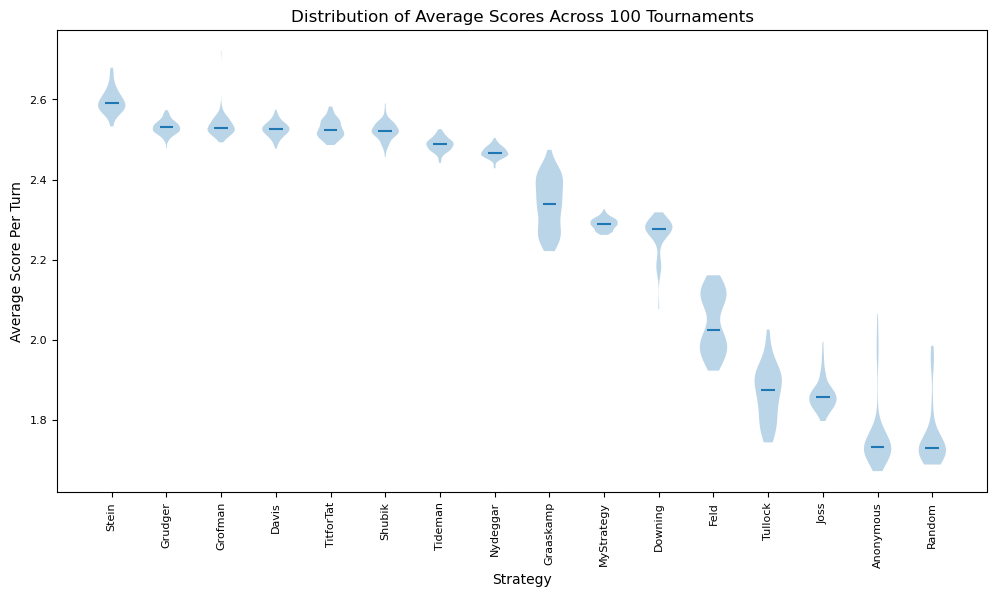

In [197]:
ticks = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64]
labels = [
    'Stein', 'Grudger', 'Grofman', 'Davis', 'TitforTat',
    'Shubik', 'Tideman', 'Nydeggar', 'Graaskamp', 'MyStrategy', 'Downing',
    'Feld','Tullock', 'Joss', 'Anonymous', 'Random'
]

plt.tight_layout()
plot = axl.Plot(results)
p = plot.boxplot()
plt.xticks(ticks = ticks,
           labels = labels)
plt.title("Distribution of Average Scores Across 100 Tournaments")
plt.ylabel("Average Score Per Turn")
plt.xlabel("Strategy")
p.show()

C:\Users\jmaxw\anaconda3\Lib\site-packages\axelrod\plot.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\jmaxw\AppData\Local\Temp\ipykernel_11708\3490345726.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.show()


<Figure size 640x480 with 0 Axes>

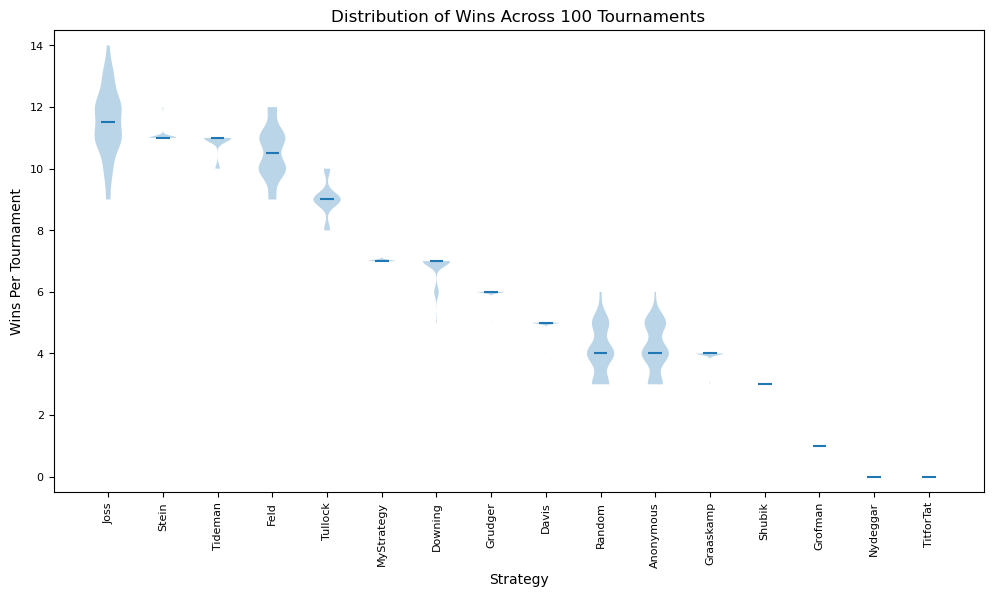

In [201]:
plt.tight_layout()
p = plot.winplot()
plt.xticks(ticks = ticks,
           labels = [
    'Joss', 'Stein', 'Tideman', 'Feld', 'Tullock',
    'MyStrategy', 'Downing', 'Grudger', 'Davis', 'Random', 'Anonymous',
    'Graaskamp','Shubik', 'Grofman', 'Nydeggar', 'TitforTat'
])
plt.title("Distribution of Wins Across 100 Tournaments")
plt.ylabel("Wins Per Tournament")
plt.xlabel("Strategy")
p.show()

C:\Users\jmaxw\anaconda3\Lib\site-packages\axelrod\plot.py:201: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\jmaxw\AppData\Local\Temp\ipykernel_11708\1737369183.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.show()


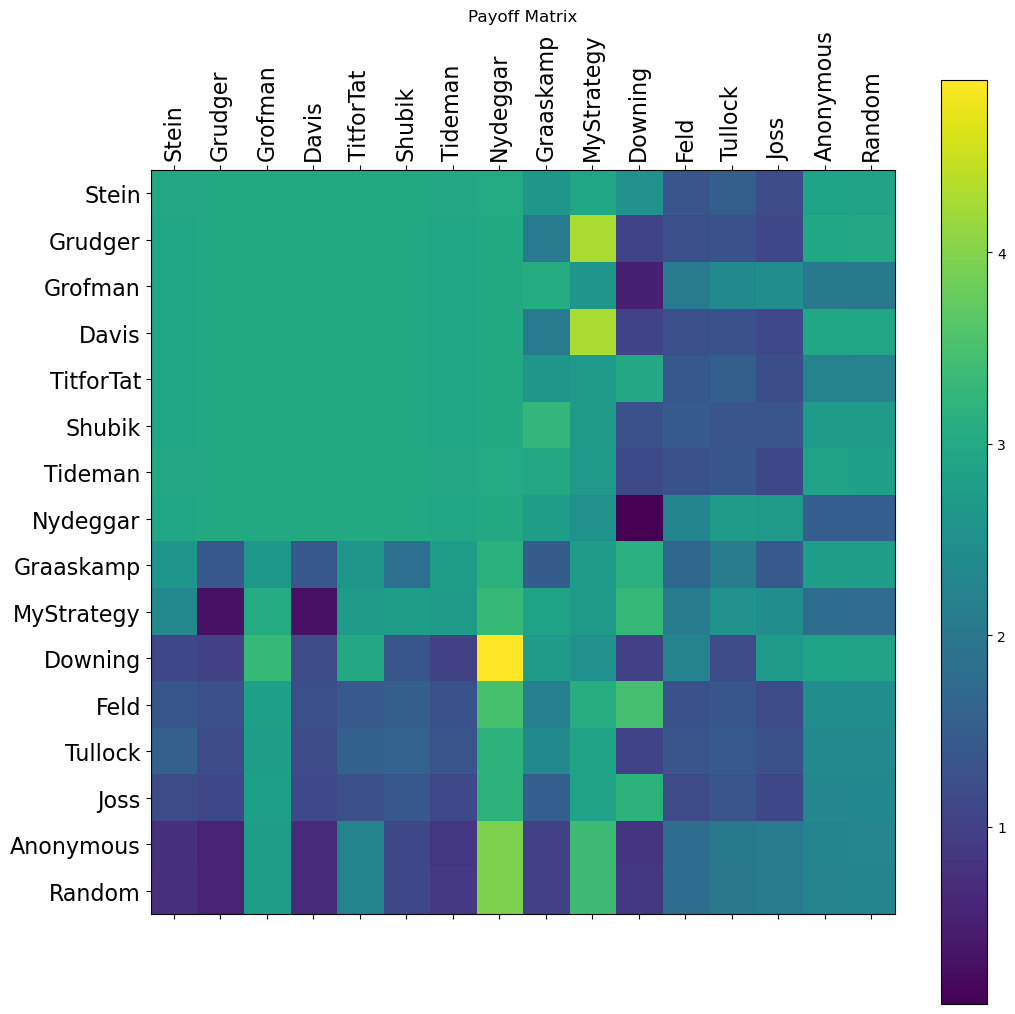

In [215]:
poticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
polabels = [
    'Stein', 'Grudger', 'Grofman', 'Davis', 'TitforTat',
    'Shubik', 'Tideman', 'Nydeggar', 'Graaskamp', 'MyStrategy', 'Downing',
    'Feld','Tullock', 'Joss', 'Anonymous', 'Random'
]
p = plot.payoff()
plt.xticks(ticks = poticks,
           labels = polabels)
plt.yticks(ticks = poticks,
           labels = polabels)
plt.title("Payoff Matrix")
p.show()